### **Importing Necessary Libraries**

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import uuid

### **Creating Floder Structure**

In [2]:
# Setup Paths
pos_path = os.path.join('Data', 'Positive')
neg_path = os.path.join('Data', 'Negative')
anc_path = os.path.join('Data', 'Anchor')

In [ ]:
# Making the Directories
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

### **Data Collection**

- #### **Negative Class**

In [ ]:
# Moving lfw images to negative directory
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        source_path = os.path.join('lfw', directory, file)
        new_path = os.path.join(neg_path, file)
        os.replace(source_path, new_path)

- #### **Possitive and Anchor Class**

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    success, frame = cap.read()

    # Cropping frames
    frame = frame[90 : 90 + 250, 240 : 240 + 250, :]

    # Collecting anchor class
    if cv2.waitKey(1) & 0XFF == ord('a'):
        img_name = os.path.join(anc_path, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(img_name, frame)


    # Collecting positive class
    if cv2.waitKey(1) & 0XFF == ord('p'):
        img_name = os.path.join(pos_path, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(img_name, frame)


    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
    

cap.release()
cv2.destroyAllWindows()

### **Loading and Preprocessing**

- #### **Loading Image Direstories**

In [3]:
anchor = tf.data.Dataset.list_files(anc_path + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path + '\*.jpg').take(300)

- #### **Preprocessing**

In [4]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Resizing the image 
    img = tf.image.resize(img, (105, 105))
    # Scale the image
    img = img / 255.0

    # Return image
    return img

In [5]:
def preprocess_dataset(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

- #### **Creating Labeled Dataset**

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

- #### **Train Test Split**

In [7]:
# Building dataloader pipeline
data = data.map(preprocess_dataset)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [8]:
# Training partition
train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [9]:
# Testing partition
test_data = data.skip(round(len(data) * .7))
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### **Model Building**

- #### **Building Embedding Layer**

In [10]:
def make_embedding(): 
    input = Input(shape = (105, 105, 3), name = 'input_image')
    
    # First block
    conv1 = Conv2D(64, (10, 10), activation = 'relu')(input)
    maxpool1 = MaxPooling2D(64, (2,2), padding = 'same')(conv1)
    
    # Second block
    conv2 = Conv2D(128, (7, 7), activation = 'relu')(maxpool1)
    maxpool2 = MaxPooling2D(64, (2,2), padding = 'same')(conv2)
    
    # Third block 
    conv3 = Conv2D(128, (4, 4), activation = 'relu')(maxpool2)
    maxpool3 = MaxPooling2D(64, (2,2), padding = 'same')(conv3)
    
    # Final embedding block
    conv4 = Conv2D(256, (4, 4), activation = 'relu')(maxpool3)
    flatten = Flatten()(conv4)
    embedding = Dense(4096, activation = 'sigmoid')(flatten)
    
    
    return Model(inputs = [input], outputs = [embedding], name = 'embedding')

In [11]:
make_embedding().summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

- #### **Distance Layer**

In [12]:
class Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

- #### **Siamese Model**

In [13]:
def make_siamese_model(): 
    

    input_image = Input(name = 'input_img', shape = (105, 105, 3))
    
    validation_image = Input(name = 'validation_img', shape = (105, 105, 3))
    
    # Embedding layer
    embedding = make_embedding()
    input_embedding = embedding(input_image)
    validation_embedding = embedding(validation_image)


    # Distance components
    siamese_layer = Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_embedding, validation_embedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name  ='SiameseNetwork')

In [14]:
siamese_model = make_siamese_model()

In [15]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

### **Model Training**

- #### **Setting Loss Function and Optimizer**

In [16]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [17]:
opt = tf.keras.optimizers.Adam(1e-4)

- #### **Setting Up Checkpoints**

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

- #### **Building Train Step Function**

In [19]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

- #### **Building Training Loop**

In [20]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


- #### **Model Building**

In [21]:
EPOCHS = 5

In [22]:
train(train_data, EPOCHS)


 Epoch 1/5
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 441s 16s/step

 Epoch 2/5
27/27 [==============================] - 480s 18s/step

 Epoch 3/5
27/27 [==============================] - 345s 13s/step

 Epoch 4/5
27/27 [==============================] - 311s 11s/step

 Epoch 5/5
27/27 [==============================] - 339s 13s/step


In [23]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [24]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [25]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[9.9958682e-01],
       [8.6672546e-05],
       [9.7471821e-01],
       [9.9308896e-01],
       [9.9418169e-01],
       [9.8853135e-01],
       [6.7596113e-05],
       [3.8161452e-04],
       [6.3696592e-05],
       [8.5953019e-05],
       [4.3499481e-04],
       [5.2088231e-01],
       [1.9621891e-03],
       [2.8213736e-04],
       [5.8583760e-01],
       [9.1852702e-04]], dtype=float32)

In [26]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]

In [27]:
y_true

array([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [28]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [29]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

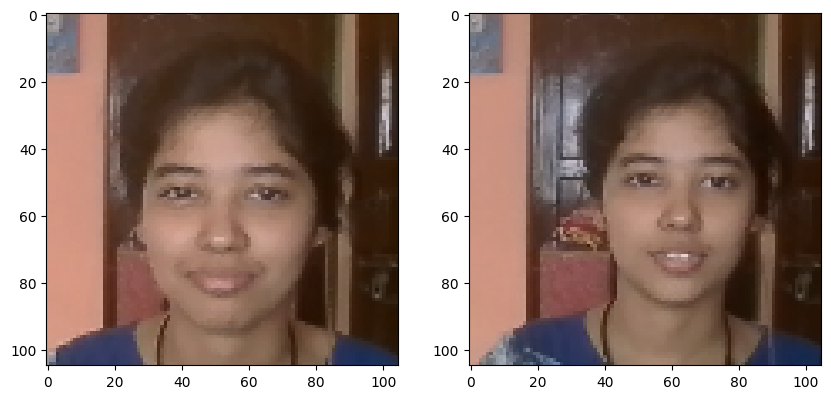

In [30]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()